## Evaluate buildings and places around a real estate listing in Somerville

In [1]:
from pyplaces import overture_maps as om
import folium

In [2]:
import geopandas as gpd
import pandas as pd
def plot_geodataframes(gdfs, zoom_start=15, popup_columns=None):
    if not isinstance(gdfs, list):
        gdfs = [gdfs]
    if popup_columns is None:
        popup_columns = [None] * len(gdfs)

    # Filter out empty GeoDataFrames
    gdfs_filtered = [(gdf, popup_columns[i]) for i, gdf in enumerate(gdfs) if not gdf.empty]

    if not gdfs_filtered:
        print("All GeoDataFrames are empty.")
        return None

    # Center the map at the centroid of the first non-empty GeoDataFrame
    all_geoms = gpd.GeoSeries(pd.concat([gdf.geometry for gdf, _ in gdfs_filtered], ignore_index=True))
    center = all_geoms.union_all().centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=zoom_start, tiles="CartoDB positron")

    for gdf, popup_col in gdfs_filtered:
        # Check if all geometries are Points
        if gdf.geometry.geom_type.isin(['Point']).all():
            for _, row in gdf.iterrows():
                coords = [row.geometry.y, row.geometry.x]
                popup = str(row[popup_col]) if popup_col and popup_col in row else None
                folium.CircleMarker(
                    location=coords,
                    radius=1,   # size of the dot
                    color='red',
                    fill=True,
                    fill_color='red',
                    fill_opacity=1,
                    popup=popup
                ).add_to(m)
        else:
            # Otherwise treat as polygon or line geometries
            if popup_col and popup_col in gdf.columns:
                folium.GeoJson(
                    gdf,
                    tooltip=folium.GeoJsonTooltip(fields=[popup_col], aliases=['Name:']),
                    popup=folium.GeoJsonPopup(fields=[popup_col])
                ).add_to(m)
            else:
                folium.GeoJson(gdf).add_to(m)

    return m


From Overture Maps, we can fetch the places and buildings within a half mile radius around address an address that we are interested in.

In [3]:
#Get the buildings and places around this address in Somerville
address = "72 Holland St, Somerville, MA"
gdf_buildings = om.overture_buildings_from_address(address,distance=0.5,unit="mi")
gdf_places = om.overture_places_from_address(address,distance=0.5,unit="mi")

#Since the names of a place are in a dictionary object, take out the primary name and put it into a new column for each place.
gdf_places['primary_name'] = gdf_places['names'].apply(lambda x: x.get('primary') if isinstance(x, dict) else None)

#Show places
gdf_places.head(5)

id                    geometry  \
0  08f2a306708e3c95036395d446f94fb5  POINT (-71.13369 42.39108)   
1  08f2a306708e3c9503d386ef500d8fda  POINT (-71.13322 42.39102)   
2  08f2a306708e02c00360c0fc4cc07f8b  POINT (-71.13306 42.39112)   
3  08f2a306708e394a0342ced905a65db6    POINT (-71.133 42.39101)   
4  08f2a306708e40c203d132bb22b9d451  POINT (-71.13295 42.39162)   

                                                bbox  version  \
0  {'xmin': -71.13369750976562, 'xmax': -71.13368...        0   
1  {'xmin': -71.13321685791016, 'xmax': -71.13320...        0   
2  {'xmin': -71.13306427001953, 'xmax': -71.13305...        0   
3  {'xmin': -71.13300323486328, 'xmax': -71.13299...        0   
4  {'xmin': -71.1329574584961, 'xmax': -71.132949...        0   

                                             sources  \
0  [{'property': '', 'dataset': 'meta', 'record_i...   
1  [{'property': '', 'dataset': 'meta', 'record_i...   
2  [{'property': '', 'dataset': 'meta', 'record_i...   
3  [{'property': '', 'dataset': 'meta', 'record_i...   
4  [{'property': '', 'dataset': 'meta', 'record_i...   

                                               names  \
0  {'primary': 'Carriegustafsonglass', 'common': ...   
1  {'primary': 'Almost Perfect Glass Inc', 'commo...   
2  {'primary': 'Sherman St Condo Tr', 'common': N...   
3  {'primary': 'NOCA Glass School', 'common': Non...   
4  {'primary': 'Abraham Watson House', 'common': ...   

                                          categories  confidence  \
0  {'primary': 'glass_blowing', 'alternate': ['ar...    0.472681   
1  {'primary': 'glass_and_mirror_sales_service', ...    0.978172   
2  {'primary': 'landmark_and_historical_building'...    0.876457   
3  {'primary': 'art_school', 'alternate': ['schoo...    0.978172   
4  {'primary': 'landmark_and_historical_building'...    0.472681   

                                            websites  \
0                  [http://Www.carriegustafson.com/]   
1               [http://www.almostperfectglass.com/]   
2                                               None   
3                  [http://www.nocaglassschool.com/]   
4  [http://en.wikipedia.org/wiki/index.html?curid...   

                                      socials emails          phones brand  \
0  [https://www.facebook.com/504041206291258]   None  [+17813674024]  None   
1  [https://www.facebook.com/339758332833589]   None  [+16174928784]  None   
2  [https://www.facebook.com/126692407970572]   None  [+16175769479]  None   
3     [https://www.facebook.com/136564065108]   None  [+16172450350]  None   
4  [https://www.facebook.com/108388655847892]   None            None  None   

                                           addresses              primary_name  
0  [{'freeform': '147 Sherman St', 'locality': 'C...      Carriegustafsonglass  
1  [{'freeform': '147 Sherman St', 'locality': 'C...  Almost Perfect Glass Inc  
2  [{'freeform': '147 Sherman St', 'locality': 'C...       Sherman St Condo Tr  
3  [{'freeform': '147 Sherman St', 'locality': 'C...         NOCA Glass School  
4  [{'freeform': None, 'locality': 'Cambridge', '...      Abraham Watson House

In [4]:
m=plot_geodataframes([gdf_buildings[["id","geometry","class"]],gdf_places[["id","geometry","primary_name"]]],popup_columns=["primary_name","class"])
m

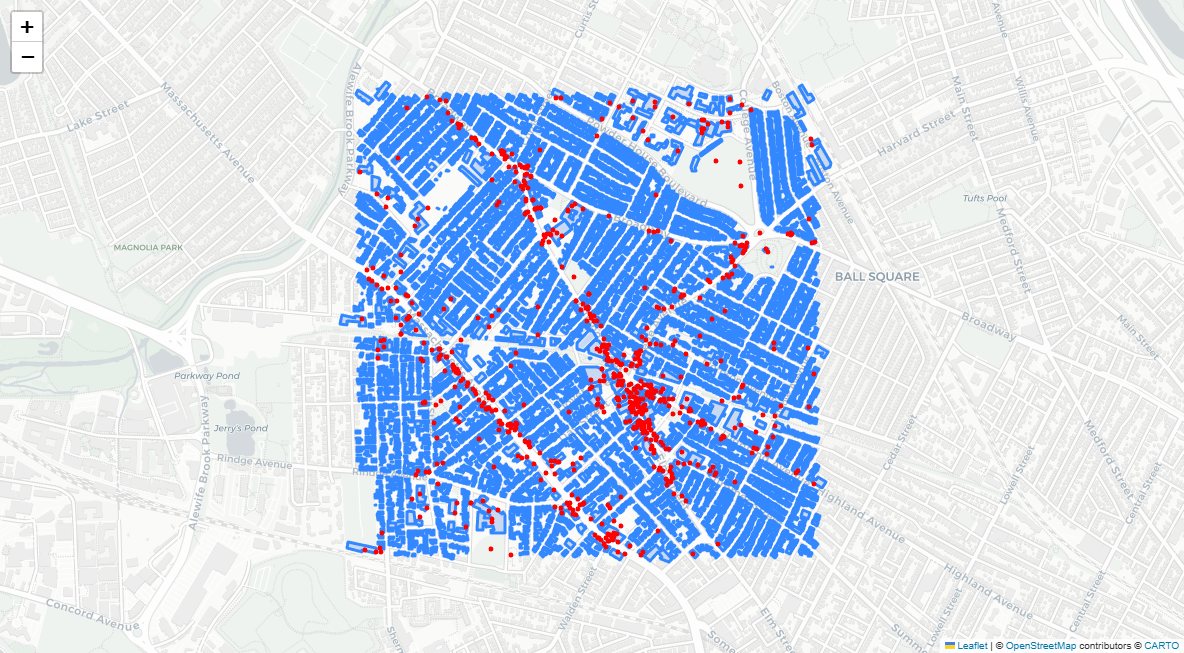

In [7]:
# Final cell to add to your notebook that will output a PNG of your Folium map

# First, save your map to an HTML file
map_html = 'temp_map.html'
m.save(map_html)  # Replace 'my_map' with your actual map variable name

# Use Selenium to convert the map to a PNG image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import os
from IPython.display import Image

# Configure Chrome in headless mode
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--window-size=1200,800")  # Adjust size as needed
driver = webdriver.Chrome(options=chrome_options)

# Load the HTML file
driver.get(f'file://{os.path.abspath(map_html)}')
time.sleep(2)  # Allow the map to fully render

# Take the screenshot
thumbnail_path = 'map_thumbnail.png'
driver.save_screenshot(thumbnail_path)
driver.quit()

# Clean up the temporary HTML file
os.remove(map_html)

# Display the image - this will be the cell output that Sphinx can use
Image(filename=thumbnail_path)